## **Import required libraries**

In [44]:
# %tensorflow_version 2.x

# import tensorflow and tensorflow.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

# import ImageDataGenerator and the related functions required for processing images
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

# import optimizers
from tensorflow.keras.optimizers import SGD, Adam, Adagrad, Adadelta, RMSprop

# import statements for building and loading the model
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.models import model_from_json

# import statements for callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# import statements for initlializers and regularizers
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.regularizers import l2

# import statements for one-hot encoding, model plotting
from tensorflow.keras.utils import to_categorical, plot_model

# import statements for loading ResNet50 from keras
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# import statements for scikit-learn
import sklearn.metrics as metrics
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# import scipy
import scipy.misc

# import os for file access
import os 

# import glob
import glob

# import numpy, pandas
import numpy as np
import pandas as pd

# import opencv
import cv2

# import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# import zipfile for unzipping the data
import zipfile

# import csv to access the csv files
import csv

# import drive to access the data from GDrive
from google.colab import drive

# import seaborn
import seaborn as sns

# import time
from time import time
print("tensorflow version:",tf.__version__)

tensorflow version: 2.3.0


## **Loading images from the dataset**

In [27]:
# Mounting the drive to the Colab Notebook for accessing the data
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [28]:
# Unzipping the folder conatining the images and data
image_data = zipfile.ZipFile("/content/drive/My Drive/state-farm-distracted-driver-detection.zip", 'r')
image_data.extractall("/tmp")
image_data.close()

In [29]:
# Specifying the location of training images after extraction
training_dir = '/tmp/imgs/train/'

In [30]:
# Loading the csv file to access the details of the images
driver_attributes = pd.read_csv('/tmp/driver_imgs_list.csv', na_values='na')

In [31]:
# Displaying top 10 values of the csv file
driver_attributes.head(10)

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg
5,p002,c0,img_3370.jpg
6,p002,c0,img_67639.jpg
7,p002,c0,img_58560.jpg
8,p002,c0,img_35779.jpg
9,p002,c0,img_10012.jpg


In [32]:
# Loading all the images from the folders containing the images
training_images = []
image_labels = []

path, dir_cs, files = next(os.walk("/tmp/imgs/train/"))
num_folders = len(files)
for i in range(10):
  print('Loaded the images of class c',i)
  imgs = os.listdir("/tmp/imgs/train/c"+str(i))
  for j in range(len(imgs)):
    img_name = "/tmp/imgs/train/c"+str(i)+"/"+imgs[j]
    # reading the images
    img = cv2.imread(img_name)
    # Converting the color space from BGR to RGB
    img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB)
    # resizing the images to size required by ResNet50
    img = cv2.resize(img, (224,224), interpolation=cv2.INTER_AREA)
    label = i
    driver_names = driver_attributes[driver_attributes['img'] == imgs[j]]['subject'].values[0]
    training_images.append([img, label, driver_names])
    image_labels.append(i)

Loaded the images of class c 0
Loaded the images of class c 1
Loaded the images of class c 2
Loaded the images of class c 3
Loaded the images of class c 4
Loaded the images of class c 5
Loaded the images of class c 6
Loaded the images of class c 7
Loaded the images of class c 8
Loaded the images of class c 9


In [33]:
import random
random.shuffle(training_images)

In [34]:
# Specifying the subject names (driver id) for validation set
validation_drivers = ['p015', 'p022', 'p050', 'p056']

In [36]:
X_train= []
y_train = []
X_val = []
y_val = []
D_train = []
D_val = []

for features, labels, drivers in training_images:
    if drivers in validation_drivers:
        X_val.append(features)
        y_val.append(labels)
        D_val.append(drivers)
    else:
        X_train.append(features)
        y_train.append(labels)
        D_train.append(drivers)

# Displaying the number of images in tarining and validation data    
print("Number of images in training set:",len(X_train))
print("Number of corresponding labels belonging to images in training set:",len(y_train))
print("Number of images in validation set:",len(X_val))
print("Number of corresponding labels belonging to images in validation set:",len(y_val))

Number of images in training set: 18732
Number of corresponding labels belonging to images in training set: 18732
Number of images in validation set: 3692
Number of corresponding labels belonging to images in validation set: 3692


In [37]:
X_train = np.array(X_train).reshape(-1,224,224,3)
X_val = np.array(X_val).reshape(-1,224,224,3)

# one-hot encoding representation of labels
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

print("Number of images in training set, image size and channels is as below:")
print (X_train.shape)

Number of images in training set, image size and channels is as below:
(18732, 224, 224, 3)


## **Model Creation**

In [ ]:
# Loading the ResNet50 model
resnet_base = ResNet50(weights= 'imagenet', include_top=False, input_shape= (224,224,3))
resnet_base.summary()

94773248/94765736 [==============================] - 3s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

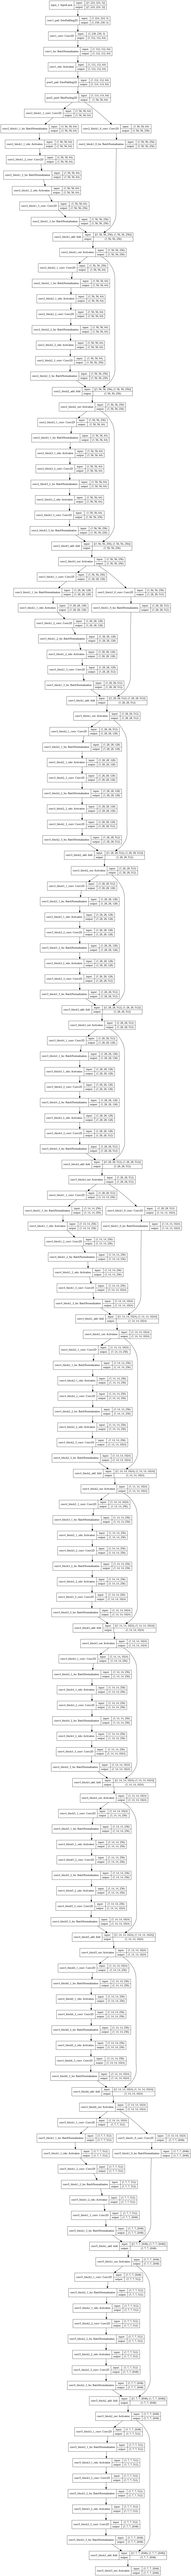

In [ ]:
# plotting the model for visualization
plot_model(resnet_base, to_file='resnet_base_figure.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Sequential building of the image classification model
# Using Keras Sequential API
model = models.Sequential()
model.add(resnet_base)
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Dense(2048, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.6))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(10, activation = 'softmax'))

In [ ]:
# Visualizing the summary of the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)             

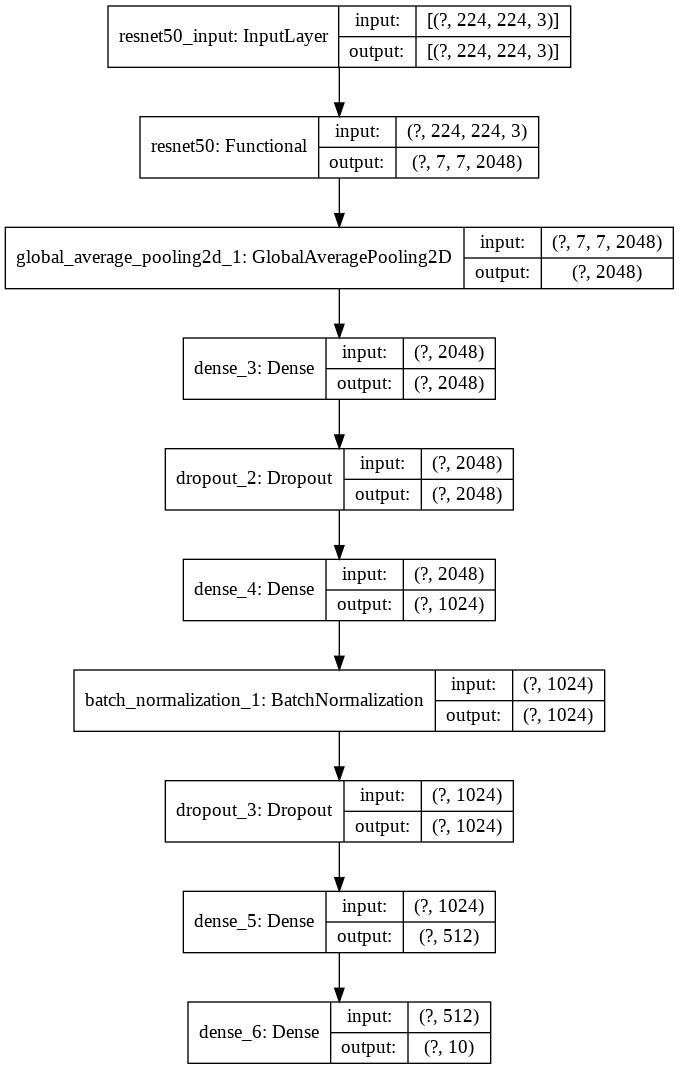

In [ ]:
# Plotting the model for visualization
plot_model(model, to_file='model_figure.png', show_shapes=True, show_layer_names=True)

## **Model Compilation**

In [ ]:
# Using Stochastic Gradient Descent as optimization algorithm
OPTIMIZER = keras.optimizers.SGD(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer = OPTIMIZER,
              metrics=['accuracy'])

In [ ]:
# Specifying the callbacks
callbacks_list= [keras.callbacks.ModelCheckpoint('Best_Classification_Model.hdf5', 
                                                 monitor='val_accuracy', 
                                                 verbose=1, 
                                                 save_best_only=True),
                 keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               patience=6, 
                                               verbose=1)]

In [ ]:
# Specifying the batch size
BATCH_SIZE= 16

# Augmenting the training images
train_datagen = ImageDataGenerator(
    height_shift_range=0.3,
    width_shift_range = 0.3,
    zoom_range = 0.2,
    rotation_range=30)

#Loading the augmented training images
training_data = train_datagen.flow(X_train, y_train, batch_size = BATCH_SIZE)

# Number of training and validation samples
training_samples = len(X_train)
validation_samples = len(X_val)

## **Train Model**

In [ ]:
# Fit the compiled model on the training data and validate with validation data
history= model.fit(training_data, steps_per_epoch= training_samples//BATCH_SIZE, 
                    callbacks=callbacks_list, 
                    epochs = 100, verbose = 1, validation_data = (X_val, y_val))

## **Visualize the execution results**

In [ ]:
# Visualize accuracy results
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.minorticks_on()
plt.grid()
plt.figure()
# save image
plt.savefig('Classification Model Accuracy', dpi=250)
plt.show()

# Visualize loss results
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.minorticks_on()
plt.grid()
plt.figure()
# save image
plt.savefig('Classification Model Loss', dpi=250)
plt.show()

## **Model Evaluation**

In [39]:
# Loading the validation images
X_val = []
y_val = []
D_val = []
true_labels = []

for features, labels, drivers in training_images:
    if drivers in validation_drivers:
      X_val.append(features)
      y_val.append(labels)
      D_val.append(drivers)
      true_labels.append(labels)

In [40]:
X_val = np.array(X_val).reshape(-1,224,224,3)

# one-hot encoding representation of labels
y_val = to_categorical(y_val)

print("Number of images in validation set, image size and channels is as below:")
print (X_val.shape)

Number of images in validation set, image size and channels is as below:
(3692, 224, 224, 3)


In [41]:
K.clear_session()

## **Load Model for Evaluation**

In [42]:
final_model = load_model('/content/drive/My Drive/CNN Model/Best_Classification_Model.hdf5')
print("Model is loaded")

In [43]:
# Display the validation accuracy and loss
results = final_model.evaluate(X_val, y_val)
print("Loss: ", results[0])
print("Accuracy: ", results[1])

116/116 [==============================] - 6s 53ms/step - loss: 0.3171 - accuracy: 0.8971
Loss:  0.3170822560787201
Accuracy:  0.8970747590065002


## **Classification Report**

In [101]:
# Creating two arrays for predicted labels

# the array will store the model's predictions
predictions = []

# maximum value of each prediction is appended
model_prediction_class = []

predictions = final_model.predict(X_val)

for i in range(len(predictions)):
    model_prediction_class.append(np.where(predictions[i] == np.amax(predictions[i]))[0][0])

val_acc = accuracy_score(true_labels,model_prediction_class)
print('Validation Accuracy:',np.around(100*(val_acc), decimals=2))

Validation Accuracy: 89.71


In [99]:
# print the classification report

print("---------------------  Classification Report  ---------------------")
print()
print(classification_report(true_labels, model_prediction_class))

---------------------  Classification Report  ---------------------

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       412
           1       0.99      0.96      0.97       339
           2       0.97      0.95      0.96       348
           3       0.94      0.99      0.97       399
           4       0.98      0.83      0.90       396
           5       0.98      0.98      0.98       403
           6       0.93      0.82      0.87       392
           7       0.90      0.97      0.93       334
           8       0.58      0.78      0.66       332
           9       0.88      0.75      0.81       337

    accuracy                           0.90      3692
   macro avg       0.90      0.90      0.90      3692
weighted avg       0.91      0.90      0.90      3692



## **Confusion Matrix**

In [100]:
# print confusion matrix with true and predicted labels

print("---------------------  Confusion Matrix  ---------------------")
print()
confusion_matrix(true_labels,model_prediction_class)

---------------------  Confusion Matrix  ---------------------



array([[386,   0,   0,   1,   0,   0,   0,   0,   2,  23],
       [  8, 326,   0,   1,   0,   0,   1,   0,   1,   2],
       [  0,   0, 332,   0,   0,   0,   0,   0,  16,   0],
       [  3,   0,   1, 394,   1,   0,   0,   0,   0,   0],
       [  3,   0,   0,   0, 327,   0,   0,   0,  64,   2],
       [  4,   0,   0,   4,   0, 393,   0,   0,   2,   0],
       [  0,   0,   3,   8,   0,   0, 320,   0,  59,   2],
       [  0,   0,   1,   0,   1,   0,   0, 324,   7,   1],
       [  1,   4,   4,   0,   1,   0,  23,  37, 258,   4],
       [ 26,   0,   0,   9,   2,  10,   0,   1,  37, 252]])

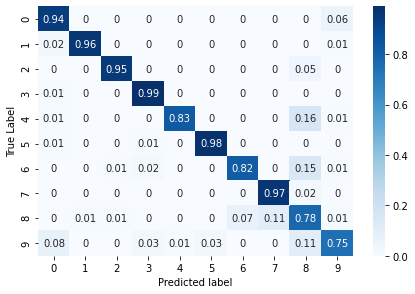

<Figure size 1440x1440 with 0 Axes>

In [93]:
# using confusion matrix from scikit-learn
# using seaborn to print the confusion matrix

# plot confusion matrix with true and predicted labels
plt_confusion_matrix = confusion_matrix(true_labels,model_prediction_class)
plt_conf_matrix = np.around(plt_confusion_matrix.astype('float') / plt_confusion_matrix.sum(axis=1)[:, np.newaxis], decimals=2)
sns.heatmap(plt_conf_matrix, annot = True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted label')
plt.savefig('Test data Confusion Matrix')
plt.figure(figsize=(20,20))
plt.show()